# Dados do Setor de Saúde

Este notebook tem como objetivo analisar os indicadores mais importantes ou principais sobre o setor de saúde suplementar, sendo eles principalmente: sinistralidade, taxa de cobertura, número de operadores e VCHM.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import src.demonstracoes_contabeis as dc

# options
pd.options.display.float_format = '{:.2f}'.format

## Sinistralidade

Segundo informações divulgada pela ANS, o cálculo da SINISTRALIDADE deve seguir a seguinte fórmula:

<br>

$$
Sinistralidade = \frac{\text{Eventos Indenizáveis Líquidos} + |CCT|}{\text{Receitas com Operações de Assistência a Saúde} + |CCT|}
$$

<br>

Essas informações nos demonstrativos contábeis correspondem aos códigos:

- Eventos Indenizáveis Líquidos - 41
- Receitas com Operações de Assistência a Saúde - 31
- Contraprestações de Corresponsabilidade Cedida (CCT) - 3117, 31171

In [92]:
data = dc.download_data(start_year=2013, end_year=2023)

data = data.drop(['DESCRICAO'], axis=1)

data.info()

/home/ian/Code/ipcap-hapvida/src/demonstracoes_contabeis.py:39: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, sep=';', encoding='latin1', on_bad_lines='skip') for f in all_csv_files), ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27829407 entries, 0 to 27829406
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DATA               object 
 1   REG_ANS            float64
 2   CD_CONTA_CONTABIL  float64
 3   VL_SALDO_INICIAL   object 
 4   VL_SALDO_FINAL     object 
 5   DT_CARGA           object 
dtypes: float64(2), object(4)
memory usage: 1.2+ GB


In [24]:
# seleciona somente as linhas relevantes do demonstrativo contabil e aplica módulo
ans_contabil = data.loc[data['CD_CONTA_CONTABIL'].isin([3117, 31171, 41, 311])].copy()

ans_contabil['VL_SALDO_FINAL'] = ans_contabil['VL_SALDO_FINAL'].apply(lambda x: float(x.replace(',', '.')))
ans_contabil['VL_SALDO_FINAL'] = np.where(ans_contabil['CD_CONTA_CONTABIL'].isin([3117, 31171]), ans_contabil['VL_SALDO_FINAL'].abs(), ans_contabil['VL_SALDO_FINAL'])

ans_contabil.sample(10).reset_index(drop=True)

,DATA,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL,DT_CARGA
0,01/10/2019,349283.00,3117.00,5135.92,NaN
1,01/01/2013,402001.00,41.00,1617799.91,NaN
2,2021-10-01,421464.00,41.00,56036.99,NaN
3,01/07/2021,311146.00,3117.00,20184094.95,NaN
4,2021-10-01,362832.00,311.00,35850780.14,NaN
5,01/07/2015,385751.00,41.00,30553455.58,NaN
6,01/01/2019,387185.00,41.00,4975286.25,NaN
7,2022-07-01,409243.00,41.00,108467907.36,NaN
8,01/07/2016,368148.00,41.00,19505756.44,NaN
9,2022-10-01,419958.00,311.00,11404631.20,NaN


In [25]:
# limpeza das datas no banco de dados
def parse_dates(str_date: str):
    for format in ('%Y-%m-%d', '%Y/%m/%d', '%d/%m/%Y'):
        try:
            return pd.to_datetime(str_date, format=format)
        except ValueError:
            continue
    return pd.NaT

ans_contabil['DATA'] = ans_contabil['DATA'].apply(parse_dates)

ans_contabil = ans_contabil.sort_values(by='DATA').reset_index(drop=True)
ans_contabil['QUARTER'] = ans_contabil['DATA'].apply(lambda x: str(x.quarter) + "T" + str(x.year)[2:4])

ans_contabil["ANO"] = ans_contabil["DATA"].dt.year

ans_contabil = ans_contabil.drop(['DT_CARGA'], axis=1)

ans_contabil.head(10).reset_index(drop=True)

,DATA,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL,QUARTER,ANO
0,2013-01-01,324175.00,41.00,1436095.86,1T13,2013
1,2013-01-01,333514.00,311.00,2076349.66,1T13,2013
2,2013-01-01,333514.00,41.00,1628325.95,1T13,2013
3,2013-01-01,333662.00,311.00,25123850.25,1T13,2013
4,2013-01-01,333662.00,41.00,19672396.73,1T13,2013
5,2013-01-01,333689.00,311.00,207838383.73,1T13,2013
6,2013-01-01,333689.00,41.00,205861636.81,1T13,2013
7,2013-01-01,333719.00,311.00,4110727.28,1T13,2013
8,2013-01-01,333719.00,41.00,4329348.12,1T13,2013
9,2013-01-01,333808.00,311.00,5253996.01,1T13,2013


In [26]:
# pivot
ans_pivot = ans_contabil.pivot_table(index=['ANO', 'QUARTER'], columns='CD_CONTA_CONTABIL', values='VL_SALDO_FINAL', aggfunc='sum').reset_index()

ans_pivot[3117] = ans_pivot[3117] + ans_pivot[31171]
ans_pivot = ans_pivot.drop(31171, axis=1)

ans_pivot = ans_pivot.rename(columns={3117: 'CCT', 311: 'RECEITAS', 41: 'DESPESAS'})
ans_pivot.columns.name = None

ans_pivot.head(10)

,ANO,QUARTER,DESPESAS,RECEITAS,CCT
0,2013,1T13,20562842033.53,26074051935.48,399235902.48
1,2013,2T13,41621047194.42,51147940625.90,790183617.28
2,2013,3T13,66314842085.29,79661190080.13,1202326789.42
3,2013,4T13,90925302327.91,109129768746.06,2149971353.68
4,2014,1T14,24221829497.70,30309092045.47,812313769.41
5,2014,2T14,50619016419.62,61465867227.62,1589046443.51
6,2014,3T14,78947913960.35,94513929142.47,2089950017.69
7,2014,4T14,106476621883.16,127740637574.28,2522511274.07
8,2015,1T15,27748857260.78,34740478406.58,445423407.98
9,2015,2T15,57862622524.96,70258319724.58,906090292.99


In [27]:
ans_pivot['SINISTRALIDADE'] = (ans_pivot['DESPESAS'] + ans_pivot['CCT']) / (ans_pivot['RECEITAS'] + ans_pivot['CCT'])

ans_pivot['SINISTRALIDADE'].describe().loc[['mean', 'std', 'min', 'max']]

mean   0.83
std    0.03
min    0.74
max    0.88
Name: SINISTRALIDADE, dtype: float64

In [28]:
ans_pivot['SINISTRALIDADE'].where(ans_pivot['QUARTER'] == '3T23').dropna()

42   0.87
Name: SINISTRALIDADE, dtype: float64

In [29]:
ans_pivot

# ans_pivot.to_csv('data/dados_agregados/ans_pivot.csv', index=False)

,ANO,QUARTER,DESPESAS,RECEITAS,CCT,SINISTRALIDADE
0,2013,1T13,20562842033.53,26074051935.48,399235902.48,0.79
1,2013,2T13,41621047194.42,51147940625.90,790183617.28,0.82
2,2013,3T13,66314842085.29,79661190080.13,1202326789.42,0.83
3,2013,4T13,90925302327.91,109129768746.06,2149971353.68,0.84
4,2014,1T14,24221829497.70,30309092045.47,812313769.41,0.80
5,2014,2T14,50619016419.62,61465867227.62,1589046443.51,0.83
6,2014,3T14,78947913960.35,94513929142.47,2089950017.69,0.84
7,2014,4T14,106476621883.16,127740637574.28,2522511274.07,0.84
8,2015,1T15,27748857260.78,34740478406.58,445423407.98,0.80
9,2015,2T15,57862622524.96,70258319724.58,906090292.99,0.83


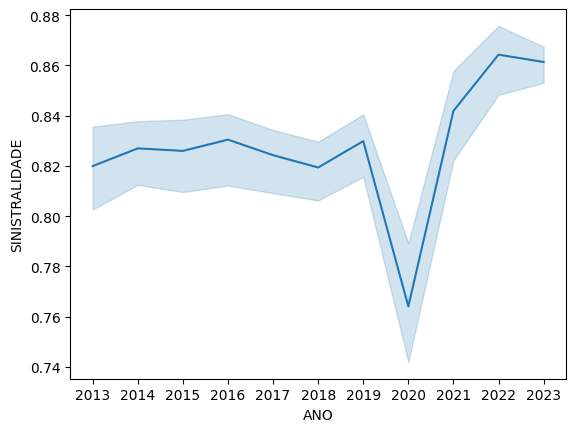

In [30]:
ans_pivot['ANO'] = ans_pivot['ANO'].astype(int)

plot = sns.lineplot(data=ans_pivot, x='ANO', y='SINISTRALIDADE')
plot.set_xticks(ans_pivot['ANO'].unique());


In [31]:
# regressão linear
X = ans_pivot['ANO'].values.reshape(-1, 1)
y = ans_pivot['SINISTRALIDADE'].values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(X, y)

print(lm.intercept_)
print(lm.coef_)


[-3.73774801]
[[0.00226228]]


In [32]:
sinistralidade_inicial = ans_pivot['SINISTRALIDADE'].loc[ans_pivot['ANO'] == 2013].mean()
taxa_crescimento_percentual = (lm.coef_[0][0] / sinistralidade_inicial) * 100

print("Taxa de Crescimento Anual: ", round(taxa_crescimento_percentual, 2))

Taxa de Crescimento Anual:  0.28


### Sinistralidade Hapvida

In [44]:
# import data

ans_contabil = data.loc[data['CD_CONTA_CONTABIL'].isin([3117, 31171, 41, 311])].copy()

ans_code = pd.read_csv('data/dados_agregados/codigo_ans.csv')

ans_code_hapvida = ans_code.loc[ans_code['OPERADORA'].isin(['Hapvida', 'Intermédica']), 'CD_ANS'].copy()

ans_code_hapvida.head(10)

12    368253
13    415847
14    351091
15    302091
16    323811
17    309338
18    339539
19    333328
20    365319
21    405604
Name: CD_ANS, dtype: int64

In [45]:
# transform data

def parse_dates(str_date: str):
    for format in ('%Y-%m-%d', '%Y/%m/%d', '%d/%m/%Y'):
        try:
            return pd.to_datetime(str_date, format=format)
        except ValueError:
            continue
    return pd.NaT

ans_contabil['VL_SALDO_FINAL'] = ans_contabil['VL_SALDO_FINAL'].apply(lambda x: float(x.replace(',', '.')))
ans_contabil['VL_SALDO_FINAL'] = np.where(ans_contabil['CD_CONTA_CONTABIL'].isin([3117, 31171]), ans_contabil['VL_SALDO_FINAL'].abs(), ans_contabil['VL_SALDO_FINAL'])

ans_contabil['DATA'] = ans_contabil['DATA'].apply(parse_dates)
ans_contabil["ANO"] = ans_contabil["DATA"].dt.year
ans_contabil['QUARTER'] = ans_contabil['DATA'].apply(lambda x: str(x.quarter) + "T" + str(x.year)[2:4])

ans_contabil = ans_contabil.sort_values(by='DATA').reset_index(drop=True)

ans_contabil = ans_contabil.drop(['DT_CARGA'], axis=1)

ans_contabil.head(10)


,DATA,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL,ANO,QUARTER
0,2013-01-01,324175.00,41.00,1436095.86,2013,1T13
1,2013-01-01,333514.00,311.00,2076349.66,2013,1T13
2,2013-01-01,333514.00,41.00,1628325.95,2013,1T13
3,2013-01-01,333662.00,311.00,25123850.25,2013,1T13
4,2013-01-01,333662.00,41.00,19672396.73,2013,1T13
5,2013-01-01,333689.00,311.00,207838383.73,2013,1T13
6,2013-01-01,333689.00,41.00,205861636.81,2013,1T13
7,2013-01-01,333719.00,311.00,4110727.28,2013,1T13
8,2013-01-01,333719.00,41.00,4329348.12,2013,1T13
9,2013-01-01,333808.00,311.00,5253996.01,2013,1T13


In [48]:
# merge data

ans_contabil['REG_ANS'] = ans_contabil["REG_ANS"].astype(int)   
ans_contabil['OPERADORA'] = np.where(ans_contabil['REG_ANS'].isin(ans_code_hapvida), 'Hapvida', 'Outros')

ans_pivot = ans_contabil.pivot_table(index=['ANO', 'QUARTER', 'OPERADORA'], columns='CD_CONTA_CONTABIL', values='VL_SALDO_FINAL', aggfunc='sum').reset_index()

ans_pivot[3117] = ans_pivot[3117] + ans_pivot[31171]
ans_pivot = ans_pivot.drop(31171, axis=1)

ans_pivot = ans_pivot.rename(columns={3117: 'CCT', 311: 'RECEITAS', 41: 'DESPESAS'})
ans_pivot.columns.name = None

ans_pivot.head(10)

,ANO,QUARTER,OPERADORA,DESPESAS,RECEITAS,CCT
0,2013,1T13,Hapvida,1071654370.43,1410823956.73,44099333.03
1,2013,1T13,Outros,19491187663.10,24663227978.75,355136569.45
2,2013,2T13,Hapvida,2227685621.61,2869606923.42,79234808.11
3,2013,2T13,Outros,39393361572.81,48278333702.48,710948809.17
4,2013,3T13,Hapvida,3502692105.48,4450327480.43,119016115.43
5,2013,3T13,Outros,62812149979.81,75210862599.70,1083310673.99
6,2013,4T13,Hapvida,4755758907.12,6162082939.96,155062711.91
7,2013,4T13,Outros,86169543420.79,102967685806.10,1994908641.77
8,2014,1T14,Hapvida,1252612071.84,1683912906.48,36288188.59
9,2014,1T14,Outros,22969217425.86,28625179138.99,776025580.82


In [51]:
# sinistralidade

ans_pivot['SINISTRALIDADE'] = (ans_pivot['DESPESAS'] + ans_pivot['CCT']) / (ans_pivot['RECEITAS'] + ans_pivot['CCT'])

ans_pivot.head(10)

# ans_pivot.to_csv('data/dados_agregados/ans_pivot_hapvida.csv', index=False)

,ANO,QUARTER,OPERADORA,DESPESAS,RECEITAS,CCT,SINISTRALIDADE
0,2013,1T13,Hapvida,1071654370.43,1410823956.73,44099333.03,0.77
1,2013,1T13,Outros,19491187663.10,24663227978.75,355136569.45,0.79
2,2013,2T13,Hapvida,2227685621.61,2869606923.42,79234808.11,0.78
3,2013,2T13,Outros,39393361572.81,48278333702.48,710948809.17,0.82
4,2013,3T13,Hapvida,3502692105.48,4450327480.43,119016115.43,0.79
5,2013,3T13,Outros,62812149979.81,75210862599.70,1083310673.99,0.84
6,2013,4T13,Hapvida,4755758907.12,6162082939.96,155062711.91,0.78
7,2013,4T13,Outros,86169543420.79,102967685806.10,1994908641.77,0.84
8,2014,1T14,Hapvida,1252612071.84,1683912906.48,36288188.59,0.75
9,2014,1T14,Outros,22969217425.86,28625179138.99,776025580.82,0.81


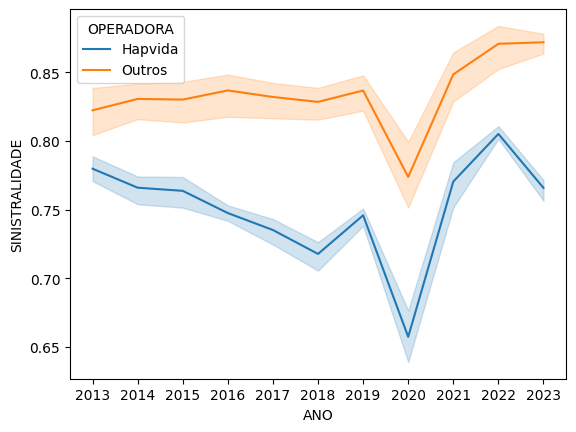

In [52]:
ans_pivot['ANO'] = ans_pivot['ANO'].astype(int)

plot = sns.lineplot(data=ans_pivot, x='ANO', y='SINISTRALIDADE', hue='OPERADORA')
plot.set_xticks(ans_pivot['ANO'].unique());

### Low-cost Provider

In [98]:
ans_margem = data.loc[data['CD_CONTA_CONTABIL'].isin([311, 41])].copy()

def parse_dates(str_date: str):
    for format in ('%Y-%m-%d', '%Y/%m/%d', '%d/%m/%Y'):
        try:
            return pd.to_datetime(str_date, format=format)
        except ValueError:
            continue
    return pd.NaT

ans_margem['VL_SALDO_FINAL'] = ans_margem['VL_SALDO_FINAL'].apply(lambda x: float(x.replace(',', '.')))

ans_margem['VL_SALDO_INICIAL'] = np.where(ans_margem['VL_SALDO_INICIAL'].isna(), 0, ans_margem['VL_SALDO_INICIAL'])
ans_margem['VL_SALDO_INICIAL'] = ans_margem['VL_SALDO_INICIAL'].astype(str)
ans_margem['VL_SALDO_INICIAL'] = ans_margem['VL_SALDO_INICIAL'].apply(lambda x: float(x.replace(',', '.')))

ans_margem['DATA'] = ans_margem['DATA'].apply(parse_dates)
ans_margem["ANO"] = ans_margem["DATA"].dt.year
ans_margem['QUARTER'] = ans_margem['DATA'].apply(lambda x: str(x.quarter) + "T" + str(x.year)[2:4])

ans_margem = ans_margem.sort_values(by='DATA').reset_index(drop=True)

ans_margem = ans_margem.drop(['DT_CARGA'], axis=1)

ans_margem['REG_ANS'] = ans_margem["REG_ANS"].astype(int)
ans_margem['CD_CONTA_CONTABIL'] = ans_margem["CD_CONTA_CONTABIL"].astype(int)  

ans_margem.tail(10)

,DATA,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_INICIAL,VL_SALDO_FINAL,ANO,QUARTER
72611,2023-07-01,415936,41,13717638.69,21242133.17,2023,3T23
72612,2023-07-01,417505,311,253219455.06,379725166.76,2023,3T23
72613,2023-07-01,417211,311,31195122.15,47615885.80,2023,3T23
72614,2023-07-01,416401,311,87361729.88,132863487.06,2023,3T23
72615,2023-07-01,415936,311,17129621.58,26462897.76,2023,3T23
72616,2023-07-01,417092,41,2.01,2.01,2023,3T23
72617,2023-07-01,416738,41,0.00,13901897.13,2023,3T23
72618,2023-07-01,416525,41,4479140.71,6518514.76,2023,3T23
72619,2023-07-01,420301,311,0.00,0.00,2023,3T23
72620,2023-07-01,316881,311,64300200.95,98942879.39,2023,3T23


In [101]:
ans_clean = ans_margem.loc[ans_margem['ANO'] >= 2018].copy()

ans_clean['REG_ANS'] = np.where(ans_clean['REG_ANS'].isin(ans_code_hapvida), 'Hapvida', 'Outros')

ans_clean['VL_CONTA'] = ans_clean['VL_SALDO_FINAL'] - ans_clean['VL_SALDO_INICIAL']

ans_grouped = ans_clean.groupby(['QUARTER', 'REG_ANS', 'CD_CONTA_CONTABIL'])['VL_CONTA'].sum().reset_index()

# ans_pivot = ans_grouped.pivot_table(index=['QUARTER', "REG_ANS"], columns='CD_CONTA_CONTABIL', values='VL_SALDO_FINAL').reset_index()

# ans_pivot = ans_clean.pivot_table(index=['QUARTER', "REG_ANS"], columns='CD_CONTA_CONTABIL', values='VL_CONTA', aggfunc='sum').reset_index()

ans_pivot = ans_pivot.rename(columns={311: 'RECEITAS', 41: 'DESPESAS'})

ans_pivot['ANO'] = ans_pivot['QUARTER'].apply(lambda x: int("20" + x[-2:]))

ans_pivot = ans_pivot.sort_values(by=['ANO', 'QUARTER']).reset_index(drop=True)
 
ans_pivot.columns.name = None

ans_grouped.head(20)

# ans_clean.reset_index(drop=True).to_csv('data/dados_agregados/lowcost_pivot.csv', index=False)

,QUARTER,REG_ANS,CD_CONTA_CONTABIL,VL_CONTA
0,1T18,Hapvida,41,2779272931.39
1,1T18,Hapvida,311,3995103174.88
2,1T18,Outros,41,34385939971.73
3,1T18,Outros,311,42614414481.28
4,1T19,Hapvida,41,3200428873.44
5,1T19,Hapvida,311,4389664052.26
6,1T19,Outros,41,37300617098.33
7,1T19,Outros,311,47147159448.73
8,1T20,Hapvida,41,3489864180.71
9,1T20,Hapvida,311,5126046069.49


In [112]:
ans_margem = data.loc[data['CD_CONTA_CONTABIL'].isin([31, 33, 41, 45, 46])].copy()

def parse_dates(str_date: str):
    for format in ('%Y-%m-%d', '%Y/%m/%d', '%d/%m/%Y'):
        try:
            return pd.to_datetime(str_date, format=format)
        except ValueError:
            continue
    return pd.NaT

ans_margem['VL_SALDO_FINAL'] = ans_margem['VL_SALDO_FINAL'].apply(lambda x: float(x.replace(',', '.')))

ans_margem['DATA'] = ans_margem['DATA'].apply(parse_dates)
ans_margem["ANO"] = ans_margem["DATA"].dt.year
ans_margem['QUARTER'] = ans_margem['DATA'].apply(lambda x: str(x.quarter) + "T" + str(x.year)[2:4])

ans_margem = ans_margem.sort_values(by='DATA').reset_index(drop=True)

ans_margem = ans_margem.drop(['DT_CARGA'], axis=1)

ans_margem['REG_ANS'] = ans_margem["REG_ANS"].astype(int)
ans_margem['CD_CONTA_CONTABIL'] = ans_margem["CD_CONTA_CONTABIL"].astype(int)  

ans_margem.tail(10)

# ans_margem.to_csv('data/dados_agregados/ans_margem.csv', index=False)

In [111]:
ans_clean = ans_margem.loc[(ans_margem['ANO'] >= 2018) & (ans_margem['REG_ANS'].isin(ans_code_hapvida))].copy()

def reverse_cumsum(group):
    return group['VL_SALDO_FINAL'] - group['VL_SALDO_FINAL'].shift(fill_value=0)

ans_clean = ans_clean.reset_index(drop=True)  # Reset the index

ans_pivot['VL_CONTA'] = ans_clean.groupby(['ANO', 'REG_ANS', 'CD_CONTA_CONTABIL']).apply(reverse_cumsum).reset_index(level=0, drop=True)

ans_pivot = ans_clean.pivot_table(index=['QUARTER', "REG_ANS"], columns='CD_CONTA_CONTABIL', values='VL_SALDO_FINAL', aggfunc='sum').reset_index()

#ans_pivot['MARGEM EBT'] = (ans_pivot['RECEITAS OPERACIONAIS'] - ans_pivot['DESPESAS OPERACIONAIS']) / (ans_pivot['RECEITAS OPERACIONAIS'])

#ans_pivot['MARGEM LÍQUIDA'] = (ans_pivot['RECEITAS OPERACIONAIS'] - ans_pivot['DESPESAS OPERACIONAIS'] - ans_pivot['JUROS'] - ans_pivot['IMPOSTOS']) / (ans_pivot['RECEITAS OPERACIONAIS'])

ans_pivot

TypeError: incompatible index of inserted column with frame index

## Taxa de Cobertura

https://medium.com/python-in-plain-english/optimizing-python-pandas-for-large-datasets-4-practical-examples-of-chunking-e94f1ec584a3

In [2]:
dict = {}

for file in os.listdir('data/fechamento'):
    temp_df = pd.read_csv(f'data/fechamento/{file}', usecols=['COBERTURA_ASSIST_PLAN', 'QT_BENEFICIARIO_ATIVO'], dtype='int32')
    
    temp_df = temp_df.loc[temp_df['COBERTURA_ASSIST_PLAN'] == 1, :].copy()
    
    num_beneficiarios = temp_df['QT_BENEFICIARIO_ATIVO'].sum()

    del temp_df

    dict[str(file)[:-6]] = num_beneficiarios

dict

{'2014': 50235905,
 '2021': 48801777,
 '2015': 49065602,
 '2017': 47007776,
 '2019': 46980240,
 '2023': 50837756,
 '2018': 47036923,
 '2022': 50108199,
 '2016': 47510376,
 '2020': 47397548}

In [27]:
# número benficários em milhões

data = pd.DataFrame.from_dict(dict, orient='index', columns=['NM_BENEFICIARIO'])

data = data.sort_index()

data = data.reset_index()

# data.to_csv('data/dados_agregados/num_beneficiarios.csv', index=False)

data

,index,NM_BENEFICIARIO
0,2014,50235905
1,2015,49065602
2,2016,47510376
3,2017,47007776
4,2018,47036923
5,2019,46980240
6,2020,47397548
7,2021,48801777
8,2022,50108199
9,2023,50837756


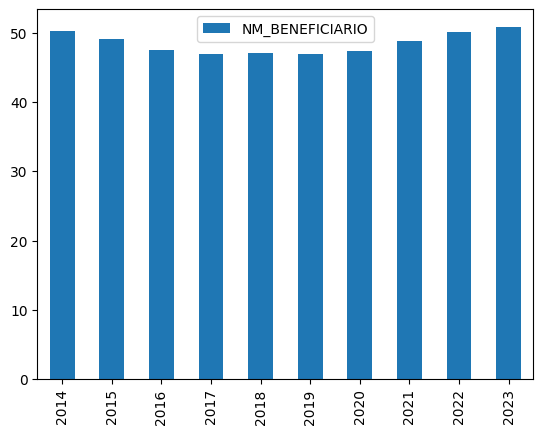

In [21]:
data.plot(kind='bar')
plt.show()


In [30]:
tx_cobertura = data.loc[data['index'] == '2023', 'NM_BENEFICIARIO']/203080756

print("Taxa de Cobertura: ", round(tx_cobertura, 2))

Taxa de Cobertura:  9   0.25
Name: NM_BENEFICIARIO, dtype: float64


In [3]:
data = pd.read_csv('data/num/202212.csv', dtype={'#ID_CMPT_MOVEL': 'category', 'QT_BENEFICIARIO_ATIVO': np.int32, 'COBERTURA_ASSIST_PLAN': np.int32})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16244393 entries, 0 to 16244392
Data columns (total 3 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   #ID_CMPT_MOVEL         category
 1   COBERTURA_ASSIST_PLAN  int32   
 2   QT_BENEFICIARIO_ATIVO  int32   
dtypes: category(1), int32(2)
memory usage: 139.4 MB
